In [3]:
# By Joachim Harnois-Deraps, with inputs from Ben Giblin on the galaxy populatio algorithm, 
# and Nan Li on some lensing subroutines 
# Code illustrating extraction of shear from Mira Titan/SkySim5000 healpix maps

import numpy as np
import healpy as hp
import random
import input
import matplotlib.pyplot as plt
import h5py


SkySim=False
HACCY1=True


#Choose Nz:
#SRD:
nz_filename='./nz_sources_srd_5bins.txt'

#Stage-IV_Euclid"
#nz_filename='./Euclid_dndz_fu08_bin1-5.dat'

# the number of galaxies per square arcminute to extract
gpam = 0.6
#gpam = 2.6    #LSST, per tomo bin
#gpam = 1.493  #KiDS tomo4
#gpam = 1.830  #KiDS tomo3
#gpam = 1.856  #KiDS tomo2
#gpam = 2.354  #KiDS tomo1

print('assigning %f gal/arcmin**2' % gpam)

# the number of galaxies to extract in the octant
ngal = int(gpam * (4.*np.pi/8.)*(180./np.pi)**2. *3600.)
print('for a total of %i galaxies' % ngal)

# The NSIDE value of the shear and weight maps
if(SkySim):
    nside = 8192
if(HACCY1):
    #nside = 4096
    nside = 8192
    seed=0 #seed = 0,1,2
    nshells=51 #nshells=19,26, 27,34, 50, 51,101,106
    IC="150_3"      #IC=150,195, 150_2, 150_3

npix = 12*nside**2
pix_size = np.sqrt(4.*np.pi*(180./np.pi*60)**2/npix)
print('pixel size of shear maps is %f arcmin per side' % pix_size)

def IndexToDeclRa(index):
        theta,phi=hp.pixelfunc.pix2ang(nside,index,nest=False)
        return np.degrees(np.pi/2. - theta),np.degrees(phi)
    
def GetNz(nz_filename,tomobin):
        print("Reading in N(z) from tomobin  %d" % tomobin)
        data = np.loadtxt(nz_filename, usecols=(0,tomobin))
        z_array = data[:,0]
        pdz = data[:,1]
        dz = z_array[41] - z_array[40]
        n_zbins = np.size(pdz)

        # Normalise:
        pdz = pdz/sum(pdz)/dz
        print("Check normalisation: sum n(z) dz = ",sum(pdz)*dz)
        print("Mean redshift = ", np.dot(pdz,z_array)*dz)
        return n_zbins,z_array, pdz,dz
    
def AssignRedshifts(n_zbins,pdz,dz):

        #construct cumulative distribution
        cumul_dist = np.zeros(n_zbins)

        for z_bin in range(0,n_zbins):
            cumul_dist[z_bin] = sum(pdz[0:z_bin+1])/sum(pdz)
            #print(z_array[z_bin], pdz[z_bin], cumul_dist[z_bin])

        print('Got cumul dist')
        
        #--------------------------------
        #draw the galaxies from this n(z) (This routine may take a few seconds to execute)
        spec_z = np.zeros(ngal)

        for gal in range(0,ngal):
            gal_bin = 0
            ran = random.uniform(0, 1)
            for z_bin in range(0,n_zbins):
                #print ran, cumul_dist[z_bin]
                if ran < cumul_dist[z_bin]:
                    gal_bin = z_bin
                    break
            
            #randomize distribution within that bin
            ran2 = random.uniform(0,1)*dz
            spec_z[gal] = z_array[gal_bin]+ran2
            #print( gal, gal_bin, z_array[gal_bin], spec_z[gal],z_array[gal_bin+1])


        print('Assigned redshift to these galaxies')
        print('-----------------------------------')
        return spec_z
    
def PlotNz(spec_z,z_array,dz,pdz,tomobin):
    
        # the histogram of the data
        n, bins, patches = plt.hist(spec_z, 60, density=True, facecolor='g',alpha=0.75)
        plt.xlabel('z')
        plt.ylabel('n(z)')
        #plt.text(60, .025, r'tomobin 1')
        plt.grid(True)

        plt.plot(z_array+dz/2, pdz)
        if tomobin==1: 
            plt.xlim(0, 0.5)
            plt.ylim(0, 4,0)
        elif tomobin==2: 
            plt.xlim(0.45, 0.85)
            plt.ylim(0, 5,0)
        elif tomobin==3: 
            plt.xlim(0.65, 1.05)
            plt.ylim(0, 5,0)
        elif tomobin==4: 
            plt.xlim(0.95, 1.45)
            plt.ylim(0, 5,0)
        elif tomobin==5: 
            plt.xlim(1.3, 3.10)
            plt.ylim(0, 5,0)

        plt.show()
        
def PopulateHACCY1(spec_z,tomobin,gpam,IC,seed,nshells):

        import healsparse
        import random
        import os

        nside_c = 32
        
        #IC=195
        #path = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC'+str(IC)+'/'
        #path = '/global/cfs/cdirs/lsst/groups/WL/projects/hos-tt/sims/L845/HACC'+str(IC)+'/'
        #path = '/pscratch/sd/x/xuod/HOS_Sims/HACC'+str(IC)+'/'
        #path = '/pscratch/sd/j/jmena/HOS_Sims/HACC'+str(IC)+'/'
        path = '/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/IA-infusion/BCM/'
        #path = '../../HACC-Y1/shear/V0/IC150/seed0/'
        #nshells = 27
        what1='gamma1'
        what2='gamma2'
        nzs='kappa_zsnapshots'
        #BCM_model='dmb'
        BCM_model='dmb_Mc2e14'

        #find galaxies between shear planes i and j, load the maps, interpolate, loop over next maps

        # Selection population option:
        # 1 = randomly choose pixels from the unmasked section of the map
        # 2 = randomly generate angular coords from the unmasked octant (more accurate than OPTION 1)
        # 3 = load mass sheet and populate the galaxies following a linear biasing scheme
        OPTION=2
        b_TA = 1.0
        dmo=False
        
        #zfile=np.loadtxt("z2ts_HACCY1_"+str(nshells)+".txt")
        

        ##tmpfile = np.load(path+"/shells_z"+str(nshells)+"_subsampleauto_groupiso/shell_hacc_seed0_shell_info.npy")
        #tmpfile = np.load(path+"/shells_z"+str(nshells)+"_nosubsample_groupisoshell_hacc_seed0_shell_info.npy")
        #tmpfile = np.load(path+"/shells_z"+str(nshells)+"_subsampleclmax100_groupiso/shell_hacc_seed0_shell_info.npy")
        #tmpfile = np.load(path+"/shells_z"+str(nshells)+"_subsampleclmax100_groupiso/shell_hacc_seed0_shell_info.npy")
        tmpfile = np.load("/pscratch/sd/j/jmena/HOS_Sims/HACC150_3/shells_z"+str(nshells)+"_subsampledensitymax1.5_nside8192/shell_hacc_seed0_shell_info.npy")
        zfile = np.zeros([nshells,5])
        for i in np.arange(nshells):
            #print(tmpfile[i][0], tmpfile[i][1], tmpfile[i][2], tmpfile[i][3], tmpfile[i][4])
            zfile[i,0:5]= [tmpfile[i][0], tmpfile[i][1], tmpfile[i][2], tmpfile[i][3], tmpfile[i][4]]
            
        #snaplist = zfile[1:107,1].astype(int)
        shell_list=np.flip(zfile[:,0])
        z_list=np.flip(zfile[:,1]) 
        z_list_front=np.flip(zfile[:,2])
        z_list_back=np.flip(zfile[:,3])
        n_slices = np.size(z_list)
        #print(zfile)
        #print(z_list)

        ngal_cur = np.zeros(n_slices, dtype=int)

        ngal_analyzed = 0
        weight_flag = 0
        recycle_map_flag = 0

        # Loop over all planes, starting from high redshift towards z=0
        # If these maps are Nested ordered, need to ring-order them.

        for plane in range(0,n_slices):
        #for plane in range(0,n_slices):

            print('starting analysis of plane %i' % plane)

            z_back = z_list_back[plane]
            z_front = z_list_front[plane]

            print('z_lo - z_mid -  z_hi =',   z_front, z_list[plane], z_back)
            gal_cur = np.where(np.logical_and(spec_z>z_front, spec_z<=z_back))
            ngal_cur[plane] = np.size(gal_cur)
            if ngal_cur[plane] == 0:
                print('no galaxies here, loop to next plane')
            else:
                print('found %s galaxies between z=%f and z=%f' % (ngal_cur[plane], z_front, z_back))
                ngal_analyzed = ngal_analyzed+ngal_cur[plane]
                #
                if ngal_cur[plane-1] >0:
                    print("Found consecutive planes not empty, recycle planes to save IO:")
                    recycle_map_flag = 1
                    # Uncomment the above to enable recycling

                #Interpolate from shear maps onto redshift of the halo:
                #! dz1 (dz2) is fractional distance to plane behind (in front)
                #
                dz1 = z_back - spec_z[gal_cur]
                if plane == n_slices -1:
                    dz2 = spec_z[gal_cur]
                else: 
                    dz2 = spec_z[gal_cur] - z_front
                #
                dz1 = dz1/(dz1 + dz2)
                dz2 = 1. - dz1
                #
                #  ishell=0 -> z=0 in Cyrille's maps, contrary to the naming from the HACC snapshots.
                ishell = int(shell_list[plane]) 

                #print(z_front, z_back, spec_z[gal_cur], dz1, dz2)


                if weight_flag == 0:
                    print('reading weight file')
                    weight_flag = 1
                    print("Reading in weight map for HACC-Y1")
                    hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
                    #hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight_4096.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
                    #
                    # masking - not really necessary here, but just in case it is useful for something else.
                    unmask = np.where(hpmap_weight > 0)[0]
                    #
                if recycle_map_flag==0:
                    print("Reading in shear 1 back (zs = %f)" % z_back)
                    print("Reading in shear 2 back (zs = %f)" % z_back)
                    fname1 = path+BCM_model+"/shear/"+str("{:5.4f}".format(z_back))+"gamma1.npy"
                    fname2 = path+BCM_model+"/shear/"+str("{:5.4f}".format(z_back))+"gamma2.npy"

                    #HACC:
                    # a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma1_imap{ishell}.fits'))
                    # a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma1_imap{ishell}.fits'))
                    # a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleclmax100_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma1_imap{ishell}.fits'))
                    # a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma1_imap{ishell}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampledensitymax1.5_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma1_imap{ishell}.fits'))
                    #hpmap_g1_back = a.generate_healpix_map()
                    #hpmap_g1_back = hp.pixelfunc.reorder(hpmap_g1_back, n2r=True)
                    
                    #BCM: 
                    hpmap_g1_back = np.load(fname1)

                    
                    print("loaded gamma1")

                        
                    #HACC:
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma2_imap{ishell}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma2_imap{ishell}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleclmax100_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma2_imap{ishell}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma2_imap{ishell}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampledensitymax1.5_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma2_imap{ishell}.fits'))
                    #hpmap_g2_back = a.generate_healpix_map()
                    #hpmap_g2_back = hp.pixelfunc.reorder(hpmap_g2_back, n2r=True)
                                       
                    #BCM: 
                    hpmap_g2_back = np.load(fname2)

                    
                    print("loaded gamma2")                                    

                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_nz{plane}_nside4096_seed{seed}.fits'))
                    #hpmap_kappa_back = a.generate_healpix_map()
                    #print("loaded kappa")                                    

                    #hp.orthview(hpmap_g1_back**2 + hpmap_g2_back**2, rot=(35, 20),half_sky=True, min=-0.1, max=0.1, title=None)
                    #hp.graticule()
                    #hp.orthview(hpmap_kappa_back, rot=(35, 20),half_sky=True, min=-0.1, max=0.1, title=None)
                    #hp.graticule()
                    #hp.mollview(hpmap_g1_back, nest=True)
                    #hp.mollview(hpmap_g2_back, nest=True)
                    #plt.show()

                else:
                    print("Recycling map to reduce IO:, zs = %f was already loaded, now used as back plane" % z_back)
                    hpmap_g1_back= hpmap_g1_front
                    hpmap_g2_back= hpmap_g2_front
                    #hpmap_kappa_back= hpmap_kappa_front

                    recycle_map_flag = 0
                #
                print("Reading in shear 1/2 front (zs = %f)" % z_front)

                if z_front==0:
                    hpmap_g1_front = hpmap_g1_back - hpmap_g1_back
                    hpmap_g2_front = hpmap_g2_back - hpmap_g2_back
                    #hpmap_kappa_front = hpmap_kappa_back - hpmap_kappa_back

                else:
                    fname1 = path+BCM_model+"/shear/"+str("{:5.4f}".format(z_front))+"gamma1.npy"
                    fname2 = path+BCM_model+"/shear/"+str("{:5.4f}".format(z_front))+"gamma2.npy"

                    #HACC:
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma1_imap{ishell - 1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleclmax100_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma1_imap{ishell - 1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma1_imap{ishell - 1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma1_imap{ishell-1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampledensitymax1.5_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma1_imap{ishell-1}.fits'))
                    #hpmap_g1_front = a.generate_healpix_map()
                    #hpmap_g1_front = hp.pixelfunc.reorder(hpmap_g1_front, n2r=True)

                    #BCM:
                    hpmap_g1_front=np.load(fname1)
                    
                    print("loaded gamma1")

                    #HACC:
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma2_imap{ishell - 1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleclmax100_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma2_imap{ishell - 1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_groupiso/{nzs}/kappa_hacc_seed{seed}_nside4096_gamma2_imap{ishell - 1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_nosubsample_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma2_imap{ishell-1}.fits'))
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampledensitymax1.5_nside8192/{nzs}/kappa_hacc_seed{seed}_nside8192_gamma2_imap{ishell-1}.fits'))
                    #hpmap_g2_front = a.generate_healpix_map()
                    #hpmap_g2_front = hp.pixelfunc.reorder(hpmap_g2_front, n2r=True)
                    
                    #BCM:
                    hpmap_g2_front=np.load(fname2)

                    print("loaded gamma2")                                    

                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_nz{plane+1}_nside4096_seed{seed}.fits'))
                    #hpmap_kappa_front = a.generate_healpix_map()
                    #print("loaded kappa")                                    


                # Got shear and kappa maps 
                #hp.mollview(hpmap_g1_back, nest=False)
                #plt.show()
                #hp.mollview(hpmap_g2_back, nest=False)
                #plt.show()              
                #hp.mollview(hpmap_g1_front, nest=False)
                #plt.show()
                #hp.mollview(hpmap_g2_front, nest=False)
                #plt.show()
                #hp.mollview(hpmap_weight, nest=False)
                #plt.show()
              
                
                


                #-------------
                if(OPTION==1):
                    # OPTION 1:
                    # randomly choose pixels from the unmasked section of the map
                    print('Getting the indicies for %s random unmasked galaxies in Mira Titan' %ngal_cur[plane])
                    #idx = np.random.choice(unmask, int(ngal_cur[plane]))
                    #print idx
                    #
                    # get the ra and dec of these pixels
                    #dec,ra= IndexToDeclRa( idx )
                    #
                    # get the shear maps at these pixels
                    #shear1_pix_front = hpmap_g1_front[idx]
                    #shear2_pix_front = hpmap_g2_front[idx]
                    #shear1_pix_back = hpmap_g1_back[idx]
                    #shear2_pix_back = hpmap_g2_back[idx]
                    #
                    #print shear1_pix_front, shear1_pix_back, dz1, dz2, shear1_pix_front*dz1 + shear1_pix_back*dz2
                    #print shear2_pix_front, shear2_pix_back, dz1, dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2
                    #
                    #
                    #np.savetxt('./MyProject/MT_nz_delta05_LSST_lmax20000_%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])
                    #np.savetxt('./MyProject/MT_nz_LSST_lmax20000_%sGpAM_zfront%s_z_back%s_recycle.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, hpmap_weight[idx],spec_z[gal_cur]])
                    #np.savetxt('./MyProject/MT_nz_LSST_lmax20000_%sGpAM_zfront%s_z_back%s_dz_flip.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz2 + shear1_pix_back*dz1, shear2_pix_front*dz2 + shear2_pix_back*dz1,hpmap_weight[idx] spec_z[gal_cur]])
                    #np.savetxt('./MyProject/MT_nz_LSST_lmax5000%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])
                    #np.savetxt('./MyProject/MT_nz_KiDS_01_09_lmax32768%sGpAM_nside%s.asc'%(gpam,nside), np.c_[ra, dec, hpmap_g1[idx], hpmap_g2[idx], hpmap_weight[idx] ])

                    #-------------
                elif(OPTION==2):
                    # OPTION 2:
                    # randomly generate angular coords from the unmasked octant, and use healpy interpolation
                    # function to get the shear at these locations
                    dec,ra = IndexToDeclRa( unmask )
                    ra_rand = np.random.uniform( np.min(ra), np.max(ra), ngal_cur[plane])
                    #
                    # This preferentially generate theta at large angles; therefore dec at small angles, near the equator.
                    # (if you randomly uniformly generate dec, you end up with all your points at the pole,
                    # and the CF looks wacky).
                    dec_rand = ( np.pi/2. - np.arccos(np.random.uniform( 0., 1., ngal_cur[plane])) ) * 180./np.pi
                    #
                    shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                    shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                     #
                    # Save a shear catalogue in standard format to be read by Athena
                    #outname = '../../../HACC-Y1/GalCat/StageIV_nz/HACC'+str(IC)+'/V0/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_JHDborn.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_clmax100.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_nosubsample.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_auto.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_nosubsample_nside8192.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192.asc'
                    #outname = input.GalDir+'StageIV_nz/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_kappa.asc'
                    outname = '../../../BCM/'+BCM_model+'/GalCat/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'

                    print("Wrinting",outname)

                    # given ra=np.degrees(phi), e2 DOES NOT NEED FLIPPING.
                    #np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur],kappa_pix_front*dz1 + kappa_pix_back*dz2 ])
                    np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur] ])

                    #-------------
                elif(OPTION==3):
                    #---------
                    # OPTION 3:
                    # Assign galaxies at positions that trace the underlying dark matter map:
                    # Based on s script from Pierre Burger, PhD Candidate, Bonn University, (2022)

                    #path_in = 'IA-infusion/SkySim5000/density/'
                    #fname = path_in+"density_map_"+str(snaplist[plane])+"_dens_allsky.npy"
                    #print("opening ", fname) 
                    #hpmap_density = np.load(fname)
                    #print("Got density file!")
                    #hp.mollview(hpmap_density[unmask], nest=False)
                    #plt.show()      
                    #must apply Octant mask

                    print("loading delta map:")

                    
                    #HACC:
                    #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampledensitymax1.5_nside8192/shell_hacc_seed{seed}_nside8192_imap{ishell}.fits'))
                    #tmp = a.generate_healpix_map()
    
                    ## turn masked pixels to zero.
                    #tmp[tmp<-1.0e+30]=0
                    
                    ## Format is nested, order into ring in order to use alm2maps transforms
                    ## and degrade NSIDE 

                    ## Or reorder, keeping all full NSIDE resolution
                    #hpmap_density = hp.reorder(tmp, n2r = True)
                    #del tmp

                    #BCM:
                    lens_str = str(plane).zfill(2)
                    #filename = '/pscratch/sd/a/avijit97/BCM/HACC/params_dependencies/full_lightcone/Mc/1e14/nshells_51/nshells_'+str(nshells)+'_imap_{}/baryonified_shells_v11.h5'.format(lens_str)
                    filename = '/pscratch/sd/a/avijit97/BCM/HACC/params_dependencies/full_lightcone/Mc/2e14/nshells_51/nshells_'+str(nshells)+'_imap_{}/baryonified_shells_v11.h5'.format(lens_str)
                    
                    with h5py.File(filename,'r') as f:
                        #print('h5py file fields:',f.keys())
                        nobaryon_shells = np.array(f['nobaryon_shells'])
                        diff_shells = np.array(f['diff_shells'])
                        #baryon_shells = nobaryon_shells+diff_shells
    
                    if(dmo):
                        hpmap_density=nobaryon_shells
                    else:
                        hpmap_density=nobaryon_shells+diff_shells 


                    print("Got RING-ordered input map")
                    # Normalize the maps correctly:       
                    mean_map = (np.mean(hpmap_density)*8.0) # no factor of 8.0 since we have full sky data here
                    hpmap_density /= mean_map 
                    hpmap_density -= 1
                    print("Transformed from number count to over-density map")

                    #hp.mollview(hpmap_density, nest=False)
                    #plt.show()


                    bias=b_TA
                    pixel_area_arcmin2=pix_size**2          
                    octant_area_arcmin2 = np.sum(hpmap_weight)*pixel_area_arcmin2
                    gpam_z= ngal_cur[plane]/octant_area_arcmin2
                    random.seed(1)

                    n_bar = gpam_z*pixel_area_arcmin2
                    #construct this equation here: n=n_bar*(1+bias*hpmap_density)   
                    hpmap_density*=bias
                    hpmap_density+=1.0
                    hpmap_density*=n_bar
                    print("Transformed from over-density to galaxy density map")

                    negative_n=np.where(hpmap_density<0)[0]
                    hpmap_density[negative_n]=0            
                    print("Enforced positivity everywhere")

                    SGD = np.random.poisson(hpmap_density)
                    print("Poisson sampled the map")

                    # Construct the pixel catalogues
                    max_gal = np.max(SGD)
                    print("max Ngal per pixel = ", max_gal)
                    pixel=np.where(SGD>0)[0]
                    positive_SGD = SGD[pixel]
                    print(pixel.shape,positive_SGD.shape)
                    max_gal = np.max(SGD)
                    print("Max number of gal per pixel = ", max_gal)
                    for i in range(1,max_gal):
                        pixel_new=np.where(SGD>i)[0]
                        print("Found ",np.shape(pixel_new), "pixels with more than ",i,"galaxies in it.")
                        print("Adding these to the pixel data vector")
                        pixel = np.hstack([pixel,pixel_new])
                        print(pixel.shape)

                    # Poisson sampling means you might endup with slightly more or less galaxies than the true deterministic input
                    # given by ngal_cur[plane]. 

                    #If too much candidates, randomly downsample pixels:
                    if(len(pixel)>=ngal_cur[plane]):
                        pixel=pixel[np.random.choice(len(pixel), size=ngal_cur[plane], replace=False)]
                    else:    
                    #If not enough candidates, randomly downsample the redshifts 
                        gal_tmp = gal_cur[0]
                        down_sampl_pix = np.random.choice(len(gal_tmp), size=len(pixel), replace=False)
                        gal_tmp = gal_tmp[down_sampl_pix]
                        dz1 = dz1[down_sampl_pix]
                        dz2 = dz2[down_sampl_pix]

                        gal_cur = gal_tmp


                    dec_rand,ra_rand = IndexToDeclRa(pixel)
                    # optional: randomly shift the position within the pixels
                    # for this, use the healpy.boundaries() function, with step=1, which
                    # returns the 4 corners of the pixel boundaries. These can be used to 
                    # sample the pixel area.

                    shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                    shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                    #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                     #
                    # Save a shear catalogue in standard format to be read by Athena/Treecorr
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192_linear_bias.asc'
                    #outname = '../../../HACC-Y1/GalCat/SRD-Y1/HACC'+str(IC)+'/noIA/seed'+str(seed)+'/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192_linear_bias_bta2.asc'
                    outname = '../../../BCM/'+BCM_model+'/GalCat/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_linear_bias.asc'
 
                    print("Wrinting",outname)
                    np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(len(pixel)),spec_z[gal_cur] ])
                    print("Done")

                    del SGD 
                    del hpmap_density




        print("***************************")
        print("Done writing all catalogues")
        print("***************************")






assigning 0.600000 gal/arcmin**2
for a total of 11138299 galaxies
pixel size of shear maps is 0.429436 arcmin per side


In [3]:
def PopulateSkySim5000(spec_z,tomobin,gpam):

    import random


    #find galaxies with shear planes i and j, load the maps, interpolate, loop over next maps
    #z_list = np.loadtxt('list_zs.dat')

    # Selection population option:
    # 1 = randomly choose pixels from the unmasked section of the map, only good for flat sky.
    # 2 = randomly generate angular coords from the unmasked octant (more accurate than OPTION 1)
    # 3 = load mass sheet and populate the galaxies following a linear biasing scheme
    OPTION=3
    b_TA=2.0

    zfile=np.loadtxt("z2ts.txt",delimiter=',')
    snaplist = np.flip(zfile[1:58,1]).astype(int)
    z_list=np.flip(zfile[1:58,0])

    n_slices = np.size(z_list)
    #print(zfile)
    #print(z_list)

    ngal_cur = np.zeros(n_slices, dtype=int)

    ngal_analyzed = 0
    weight_flag = 0
    recycle_map_flag = 0

    # Loop over all planes, starting from high redshift towards z=0
    #for plane in range(36,37):
    for plane in range(0,n_slices):

        print('starting analysis of plane %i' % plane)

        #--------------------------------------
        # Get redshifts of the source planes:
        z_back = z_list[plane]
        if plane == n_slices-1:
            z_front = 0.0
        else:
            z_front = z_list[plane+1]
        print('z_lo - z_hi =', z_front, z_back)
        #--------------------------------------



        gal_cur = np.where(np.logical_and(spec_z>z_front, spec_z<=z_back))
        ngal_cur[plane] = np.size(gal_cur)
        if ngal_cur[plane] == 0:
            print('no galaxies here, loop to next plane')
        else:
            print('found %s galaxies between z=%f and z=%f' % (ngal_cur[plane], z_front, z_back))
            ngal_analyzed = ngal_analyzed+ngal_cur[plane]
            #
            if ngal_cur[plane-1] >0:
                print("Found consecutive planes not empty, recycle planes to save IO:")
                recycle_map_flag = 1
                # Uncomment the above to enable recycling

            #Interpolate from shear maps onto redshift of the halo:
            #! dz1 (dz2) is fractional distance to plane behind (in front)
            #
            dz1 = z_back - spec_z[gal_cur]
            if plane == n_slices -1:
                dz2 = spec_z[gal_cur]
            else: 
                dz2 = spec_z[gal_cur] - z_front
            #
            dz1 = dz1/(dz1 + dz2)
            dz2 = 1. - dz1
            #
            #print(z_front, spec_z[gal_cur], z_back, dz1, dz2)

            if weight_flag == 0:
                print('reading weight file')
                weight_flag = 1
                print("Reading in weight map for OuterRim/Mira Titan")
                hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
                #
                # masking - not really necessary here, but just in case it is useful for something else.
                unmask = np.where(hpmap_weight > 0)[0]
                #
            if recycle_map_flag==0:
                print("Reading in shear 1 back (zs = %f)" % z_back)
                print("Reading in shear 2 back (zs = %f)" % z_back)

                fname1 = "../../shear/"+str("{:5.4f}".format(z_back))+"gamma1.npy"
                fname2 = "../../shear/"+str("{:5.4f}".format(z_back))+"gamma2.npy"
                #fname3 = input.kappaDir+str("{:5.4f}".format(z_back))+"kappa.npy"

                hpmap_g1_back = np.load(fname1)
                print("loaded gamma1")

                hpmap_g2_back = np.load(fname2)
                print("loaded gamma2")                                    

                #hpmap_kappa_back = np.load(fname3)
                #print("loaded kappa")                                    


            else:
                print("Recycling map to reduce IO:, zs = %f was already loaded, now used as back plane" % z_back)
                hpmap_g1_back= hpmap_g1_front
                hpmap_g2_back= hpmap_g2_front
                #hpmap_kappa_back= hpmap_kappa_front

                recycle_map_flag = 0
            #
            print("Reading in shear 1/2/kappa front (zs = %f)" % z_front)

            if z_front==0:
                hpmap_g1_front = hpmap_g1_back - hpmap_g1_back
                hpmap_g2_front = hpmap_g2_back - hpmap_g2_back
                #hpmap_kappa_front = hpmap_kappa_back - hpmap_kappa_back

            else:
                fname1 = "../../shear/"+str("{:5.4f}".format(z_front))+"gamma1.npy"
                fname2 = "../../shear/"+str("{:5.4f}".format(z_front))+"gamma2.npy"
                #fname3 = input.kappaDir+str("{:5.4f}".format(z_front))+"kappa.npy"


                hpmap_g1_front = np.load(fname1)
                print("loaded gamma1")

                hpmap_g2_front = np.load(fname2)
                print("loaded gamma2")                                    

                #hpmap_kappa_front = np.load(fname3)
                #print("loaded kappa")                                    


            # Got shear and kappa maps 


            #-------------
            if(OPTION==1):
                # OPTION 1:
                # randomly choose pixels from the unmasked section of the map
                # Only good for flat sky.
                print('Getting the indicies for %s random unmasked galaxies' %ngal_cur[plane])
                idx = np.random.choice(unmask, int(ngal_cur[plane]))
                #print idx
                #
                # get the ra and dec of these pixels
                dec,ra= IndexToDeclRa( idx )
                #
                # get the shear maps at these pixels
                shear1_pix_front = hpmap_g1_front[idx]
                shear2_pix_front = hpmap_g2_front[idx]
                shear1_pix_back = hpmap_g1_back[idx]
                shear2_pix_back = hpmap_g2_back[idx]
                #
                np.savetxt('./MyProject/MT_nz_LSST_lmax5000%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])

                #-------------
            elif(OPTION==2):
                # OPTION 2:
                # randomly generate angular coords from the unmasked octant, and use healpy interpolation
                # function to get the shear at these locations
                dec,ra = IndexToDeclRa( unmask )
                ra_rand = np.random.uniform( np.min(ra), np.max(ra), ngal_cur[plane])
                #
                # This preferentially generate theta at large angles; therefore dec at small angles, near the equator.
                # (if you randomly uniformly generate dec, you end up with all your points at the pole,
                # and the CF looks wacky).
                dec_rand = ( np.pi/2. - np.arccos(np.random.uniform( 0., 1., ngal_cur[plane])) ) * 180./np.pi
                #
                shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                 #
                # Save a shear catalogue in standard format to be read by Athena
                #outname = "../../GalCat/"+'StageIV_nz/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w.asc'
                outname = '../../GalCat/SRD-Y1/random_pos/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'
                #outname = input.GalDir+'StageIV_nz/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_kappa.asc'

                print("Wrinting",outname)

                # given ra=np.degrees(phi), e2 DOES NOT NEED FLIPPING.
                #np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur],kappa_pix_front*dz1 + kappa_pix_back*dz2 ])
                np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur] ])

                #-------------
            elif(OPTION==3):
                #---------
                # OPTION 3:
                # Assign galaxies at positions that trace the underlying dark matter map:
                # Based on a script from Pierre Burger, PhD Candidate, Bonn University, (2022)
    
                smoothing = '1' #'None', 1, '05' or '01'
    
                if (smoothing=='None'): 
                    path_in="/global/cfs/cdirs/lsst/groups/CS/mass_sheets/"
                    print("loading delta map:")
                    fname = path_in+'density_map_'+str(snaplist[plane])+'_dens.bin'
                    print('Working on file '+fname)
                    tmp = np.fromfile(fname,'<f')

                    # Format is nested, reorder pixels into ring in order to use alm2maps transforms
                    # and potentially degrade NSIDE 
                    #print("NSIDE_orig=", hp.get_nside(tmp))
                    #binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)
                    #print("NSIDE_new=", hp.get_nside(binmap))

                    # Or reorder, keeping all full NSIDE resolution
                    hpmap_density = hp.reorder(tmp, n2r = True)
                    del tmp

                else:
                    fname='../../density/density_'+str(snaplist[plane])+'_smooth_'+smoothing+'arcmin.npy'
                    hpmap_density = np.load(fname)
                    
                print("Got RING-ordered input map")
                # Normalize the maps correctly:       
                mean_map = (np.mean(hpmap_density)*8.0) # factor of 8.0 since we have octant
                hpmap_density /= mean_map 
                hpmap_density -= 1
                hpmap_density*=hpmap_weight # Applied mask
                print("Transformed from number count to over-density map, with mask")

               
                bias=b_TA
                pixel_area_arcmin2=pix_size**2          
                octant_area_arcmin2 = np.sum(hpmap_weight)*pixel_area_arcmin2
                gpam_z_per_arcmin2= ngal_cur[plane]/octant_area_arcmin2
                random.seed(1)

                n_bar = gpam_z_per_arcmin2*pixel_area_arcmin2 # mean number of galaxies per pixel
                #------------------------
                #construct this equation: n(x)=n_bar*(1+bias*delta(x))   
                #------------------------
                
                hpmap_density*=bias
                hpmap_density+=1.0
                hpmap_density*=n_bar
                hpmap_density*=hpmap_weight # Applied mask

                print("Transformed from over-density to galaxy density map")

                negative_n=np.where(hpmap_density<0)[0]
                hpmap_density[negative_n]=0            
                print("Enforced positivity everywhere")

                SGD = np.random.poisson(hpmap_density)
                print("Poisson sampled the map")

                # Construct the catalogues
                max_gal = np.max(SGD)
                print("max Ngal per pixel = ", max_gal)
                pixel=np.where(SGD>0)[0]
                positive_SGD = SGD[pixel]
                print(pixel.shape,positive_SGD.shape)
                max_gal = np.max(SGD)
                print("Max number of gal per pixel = ", max_gal)
                for i in range(1,max_gal):
                    pixel_new=np.where(SGD>i)[0]
                    print("Found ",np.shape(pixel_new), "pixels with more than ",i,"galaxies in it.")
                    print("Adding these to the pixel data vector")
                    pixel = np.hstack([pixel,pixel_new])
                    print(pixel.shape)

                # Poisson sampling means you might endup with slightly more or less galaxies than the true deterministic input
                # given by ngal_cur[plane]. 

                #If too much candidates, randomly downsample pixels:
                if(len(pixel)>=ngal_cur[plane]):
                    pixel=pixel[np.random.choice(len(pixel), size=ngal_cur[plane], replace=False)]
                else:    
                #If not enough candidates, randomly downsample the redshifts 
                    gal_tmp = gal_cur[0]
                    down_sampl_pix = np.random.choice(len(gal_tmp), size=len(pixel), replace=False)
                    gal_tmp = gal_tmp[down_sampl_pix]
                    dz1 = dz1[down_sampl_pix]
                    dz2 = dz2[down_sampl_pix]

                    gal_cur = gal_tmp
                    
                dec_rand,ra_rand = IndexToDeclRa(pixel)

                
                #----------
                #hp.mollview(hpmap_density, nest=False)
                #plt.show()
                #----------
                lonra = [0, 2]
                latra = [0, 1]
                hp.cartview(hpmap_density,
                    cbar=True, lonra=lonra, latra=latra,
                    nest=False,
                    title=" ",
                    # min=-10, max=0,
                    cmap=plt.cm.coolwarm,
                    norm=None, unit='delta')
                #plt.show()
                                
                hp.projscatter(ra_rand,dec_rand,lonlat=True,marker=(5, 2),c='tab:orange',alpha=0.5)
                plt.show()
 
                
                # optional: randomly shift the position within the pixels
                # for this, use the healpy.boundaries() function, with step=1, which
                # returns the 4 corners of the pixel boundaries. These can be used to 
                # sample the pixel area.

                shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                 #
                # Save a shear catalogue in standard format to be read by Athena/Treecorr
                if (smoothing=='None'): 
                    #outname = '../../GalCat/StageIV_nz/V1/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias.asc'
                    #outname = '../../GalCat/StageIV_nz/V1/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias_bta2.asc'
                    #outname = '../../GalCat/SRD-Y1/V1/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias_bta2.asc'
                    #outname = '../../GalCat/SRD-Y1/lin_bias_pos/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias_bta1.asc'
                    outname = '../../GalCat/SRD-Y1/lin_bias_pos/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias_bta2.asc'
                else:
                    #outname = '../../GalCat/SRD-Y1/lin_bias_pos/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias_smooth'+smoothing+'_bta1.asc'
                    outname = '../../GalCat/SRD-Y1/lin_bias_pos/GalCat_tomo'+str(tomobin)+'_plane'+str(plane)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias_smooth'+smoothing+'_bta2.asc'
                   
                print("Wrinting",outname)
                np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(len(pixel)),spec_z[gal_cur] ])
                print("Done")

                del SGD 
                del hpmap_density




    print("***************************")
    print("Done writing all catalogues")
    print("***************************")

    

In [ ]:
#run pipeline:
    
# The tomographic bin
for tomobin in range(1,6):
    
    print("**************************")
    print("Processing tomo bin",tomobin)
    print("**************************")
    
    # 1- Read N(z)    
    n_zbins,z_array,pdz,dz = GetNz(nz_filename,tomobin)

    # 2- Assign Redshifts
    spec_z = AssignRedshifts(n_zbins,pdz,dz)

    # 3- Plot input n(z) vs galaxy histogram
    PlotNz(spec_z,z_array,dz,pdz,tomobin)

    # 4- Make catalogue
    if(SkySim):
        PopulateSkySim5000(spec_z,tomobin,gpam)
    else:
        PopulateHACCY1(spec_z,tomobin,gpam,IC,seed,nshells)

    

In [5]:
# Concatenate catalogues:
import os

if(SkySim):
    print('Concatenating SkySim5000 plane catalogues')
    #os.system("for tomo in {1..1}; do echo 'working on tomo'$tomo; ls -l   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.6GpAM*; done")
    #os.system("for tomo in {1..1}; do cat   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.6GpAM* > /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/GalCat_tomo$tomo'_All_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    #os.system("for tomo in {5..5}; do echo 'working on tomo'$tomo; ls -l   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.06GpAM_RA_Dec_g1_g2_w_linear_bias.asc; done")
    #os.system("for tomo in {5..5}; do cat   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.06GpAM_RA_Dec_g1_g2_w_linear_bias.asc > /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/V1/GalCat_tomo$tomo'_All_0.06GpAM_RA_Dec_g1_g2_w_z_linear_bias.asc'; done")
    os.system("for tomo in {1..5}; do echo 'working on tomo'$tomo; ls -l   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/SRD-Y1/lin_bias_pos/*tomo$tomo*0.6GpAM_RA_Dec_g1_g2_w_linear_bias_smooth01_bta1.asc; done")
    os.system("for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/SRD-Y1/lin_bias_pos/*tomo$tomo*0.6GpAM_RA_Dec_g1_g2_w_linear_bias_smooth01_bta1.asc > /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/SRD-Y1/lin_bias_pos/GalCat_tomo$tomo'_All_0.6GpAM_RA_Dec_g1_g2_w_z_linear_bias_smooth01_bta1.asc'; done")

    
if(HACCY1):
    print('Concatenating HACC plane catalogues')
    #GpAM='0.06':
    #os.system("let tomo=5; ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells19_0.06GpAM*")
    #os.system("let tomo=5; cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells19_0.06GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/GalCat_tomo$tomo'_All_nshells19_0.06GpAM_RA_Dec_g1_g2_w_z.asc'")

    #GpAM='0.6':
    #os.system("let tomo=5; ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells106_0.6GpAM*")
    #os.system("let tomo=5; cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells106_0.6GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/GalCat_tomo$tomo'_All_nshells106_0.6GpAM_RA_Dec_g1_g2_w_z.asc'")
    #os.system("for tomo in {1..5}; do  ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed0/*tomo$tomo*nshells106_0.06GpAM*; done")
    #os.system("for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed0/*tomo$tomo*nshells106_0.06GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed0/GalCat_tomo$tomo'_All_nshells106_0.06GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    #os.system("for tomo in {1..5}; do ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed2/*tomo$tomo*nshells50_0.6GpAM* ; done"); 
    #os.system("for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed2/*tomo$tomo*nshells50_0.6GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed2/GalCat_tomo$tomo'_All_nshells50_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    #os.system("let seed=1; let nshells=27; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_2/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'* ; done"); 
    #os.system("let seed=1; let nshells=27; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_2/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_2/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*clmax100.asc ; done"); 
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*clmax100.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_zclmax100.asc'; done")
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*nosubsample.asc ; done"); 
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*nosubsample.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z_nosubsample.asc'; done")
    #os.system("let seed=0; let nshells=106; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'* ; done"); 
    #os.system("let seed=0; let nshells=106; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192.asc ; done"); 
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192.asc'; done")
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*nosubsample_nside8192.asc ; done"); 
    #os.system("let seed=0; let nshells=26; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*nosubsample_nside8192.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z_nosubsample_nside8192.asc'; done")
    #os.system("let seed=0; let nshells=101; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192.asc ; done"); 
    #os.system("let seed=0; let nshells=101; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192.asc'; done")
    #os.system("let seed=0; let nshells=101; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192_linear_bias_bta2.asc ; done"); 
    #os.system("let seed=0; let nshells=101; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192_linear_bias_bta2.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192_linear_bias_bta2.asc'; done")
    #os.system("let seed=0; let nshells=101; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192_linear_bias.asc ; done"); 
    #os.system("let seed=0; let nshells=101; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*subsampledensitymax_nside8192_linear_bias.asc > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192_linear_bias.asc'; done")

    #BCM:
    #os.system("let seed=0; let nshells=51; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/BCM/dmb/GalCat/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*z.asc ; done"); 
    #os.system("let seed=0; let nshells=51; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/BCM/dmb/GalCat/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*z.asc > /global/homes/j/jharno/IA-infusion/BCM/dmb/GalCat/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    os.system("let seed=0; let nshells=51; for tomo in {1..5}; do ls -l /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*z.asc ; done"); 
    os.system("let seed=0; let nshells=51; for tomo in {1..5}; do cat   /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/*tomo$tomo*plane*nshells$nshells'_0.6GpAM'*z.asc > /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo$tomo'_All_nshells'$nshells'_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    

Concatenating HACC plane catalogues
-rw-rw---- 1 jharno lsst      1815 Nov 25 11:59 /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane25_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc
-rw-rw---- 1 jharno lsst     22493 Nov 25 11:59 /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane26_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc
-rw-rw---- 1 jharno lsst    205760 Nov 25 12:00 /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane27_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc
-rw-rw---- 1 jharno lsst   1185784 Nov 25 12:00 /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane28_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc
-rw-rw---- 1 jharno lsst   5005651 Nov 25 12:00 /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane29_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc
-rw-rw---- 1 jharno lsst  14655216 Nov 25 12:01 /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane30_nshells51_0.6

In [11]:
# Clean up catalogues for boundary effects, where shear is sometimes -1e30...
# Must run after concatenating the plane catalogues
seed=0
nshells=51
GpAM = 0.6
if(HACCY1):
    #HACC
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed'+str(seed)+'/'
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_2/noIA/seed'+str(seed)+'/'
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed'+str(seed)+'/'
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150/noIA/seed'+str(seed)+'/'
    
    #BCM:
    path='/global/homes/j/jharno/IA-infusion/BCM/dmb/GalCat/'
    
    for tomo in range(1,6):
        
        #HACC:
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_nosubsample.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_nosubsample.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_zclmax100.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_clmax100.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_subsampledensitymax_nside8192.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_nosubsample_nside8192.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_nosubsample_nside8192.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192_linear_bias.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_subsampledensitymax_nside8192_linear_bias.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192_linear_bias_bta2.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_subsampledensitymax_nside8192_linear_bias_bta2.asc'

        #BCM:
        fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(GpAM)+'GpAM_RA_Dec_g1_g2_w_z.asc'
        fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(GpAM)+'GpAM_RA_Dec_g1_g2_w_z_good.asc'
        
        GalCat = np.loadtxt(path+fname_in)
        Good_cat = GalCat[GalCat[:,3]>-1]
        veryGood_cat = Good_cat[Good_cat[:,3]<10]
        np.savetxt(path+fname_out,veryGood_cat)

        Bad_cat = GalCat[GalCat[:,3]<-1]
        veryBad_cat = Bad_cat[Bad_cat[:,3]>10]

        print("Removed "+str(np.shape(veryBad_cat)[0])+" bad galaxies")
        print('Cleaned GalCat for tomo',tomo)

Removed 0 bad galaxies
Cleaned GalCat for tomo 1
Removed 0 bad galaxies
Cleaned GalCat for tomo 2
Removed 0 bad galaxies
Cleaned GalCat for tomo 3
Removed 0 bad galaxies
Cleaned GalCat for tomo 4
Removed 0 bad galaxies
Cleaned GalCat for tomo 5


In [13]:
# Clean up catalogues for boundary effects, where shear is sometimes -1e30...
# Must run after concatenating the plane catalogues
seed=0
nshells=51
if(HACCY1):
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed'+str(seed)+'/'
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_2/noIA/seed'+str(seed)+'/'
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed'+str(seed)+'/'
    #path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150/noIA/seed'+str(seed)+'/'

    #BCM:
    path='/global/homes/j/jharno/IA-infusion/BCM/dmb/GalCat/'

    
    for tomo in range(1,6):
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_nosubsample.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_nosubsample.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_zclmax100.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_clmax100.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_subsampledensitymax_nside8192.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_subsampledensitymax_nside8192.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_nosubsample_nside8192.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_nosubsample_nside8192.asc'
        #fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_good_subsampledensitymax_nside8192_linear_bias.asc'
        #fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(gpam)+'GpAM_RA_Dec_g1_g2_w_z_verygood_subsampledensitymax_nside8192_linear_bias.asc'

        #BCM:
        fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(GpAM)+'GpAM_RA_Dec_g1_g2_w_z.asc'
        fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+str(GpAM)+'GpAM_RA_Dec_g1_g2_w_z_good.asc'

        GalCat = np.loadtxt(path+fname_in)
        Good_cat = GalCat[GalCat[:,3]<10]
        np.savetxt(path+fname_out,Good_cat)
        Bad_cat = GalCat[GalCat[:,3]>1]
        print("Removed "+str(np.shape(Bad_cat)[0])+" bad galaxies")
        print('Cleaned GalCat for tomo',tomo)

Removed 0 bad galaxies
Cleaned GalCat for tomo 1
Removed 0 bad galaxies
Cleaned GalCat for tomo 2
Removed 0 bad galaxies
Cleaned GalCat for tomo 3
Removed 0 bad galaxies
Cleaned GalCat for tomo 4
Removed 0 bad galaxies
Cleaned GalCat for tomo 5


In [6]:
# Remove temporary products
#os.system("ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed1/*plane*")
#os.system("cat     /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed1/*plane*")
# Might not always work on jupyter notebook, as it involves too much data being erased, clean up in terminal instead...

# clean up the un-good galaxy products:
#os.system("let seed=2;rm -v   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/HACC150/V0/seed$seed/*g1_g2_w_z.asc")
#os.system("let seed=1;rm -v   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*plane*")
#os.system("let seed=0;rm -v   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed$seed/*plane*")
#os.system("rm -v   /global/homes/j/jharno/IA-infusion/BCM/dmb/GalCat/*plane*")
os.system("rm -v   /global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/*plane*")



removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane25_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane26_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane27_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane28_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane29_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane30_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane31_nshells51_0.6GpAM_RA_Dec_g1_g2_w_z.asc'
removed '/global/homes/j/jharno/IA-infusion/BCM/dmb_Mc2e14/GalCat/GalCat_tomo1_plane32_nshells51_0.6GpAM_RA_Dec

0

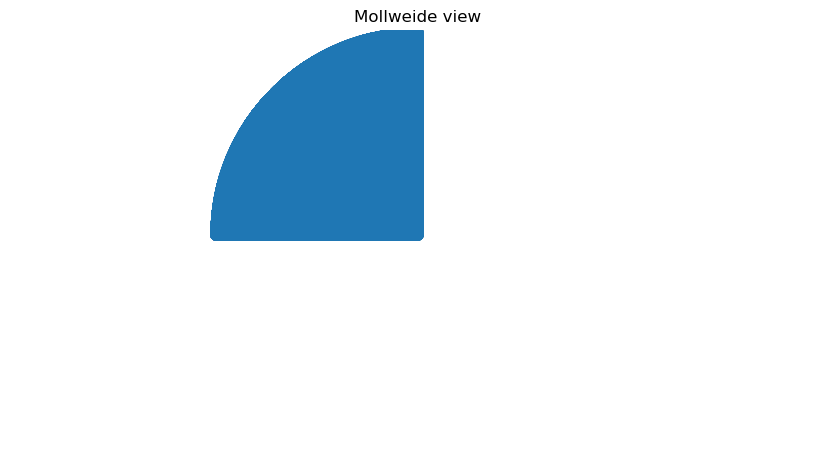

In [17]:
# Visualise HACC-Y1 catalogue
seed = 0
GpAM='0.6'
path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/SRD-Y1/HACC150_3/noIA/seed'+str(seed)+'/'

for tomo in range(2,3):
    fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+GpAM+'GpAM_RA_Dec_g1_g2_w_z_good_subsampledensitymax_nside8192_linear_bias.asc'
    GalCat = np.loadtxt(path+fname_in)
    
    hp.mollview()
    hp.projscatter(GalCat[:,0],GalCat[:,1], lonlat=True)
    plt.show()

In [ ]:
plane=33
fname = path_in+'density_map_'+str(snaplist[plane])+'_dens.bin'

print('Working on file '+fname)
tmp = np.fromfile(fname,'<f')

# Format is nested, order into ring in order to use alm2maps transforms
# and degrade NSIDE 
#print("NSIDE_orig=", hp.get_nside(tmp))
#binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)
#print("NSIDE_new=", hp.get_nside(binmap))

# Or reorder, keeping all full NSIDE resolution
hpmap_density = hp.reorder(tmp, n2r = True)
del tmp
hp.mollview(hpmap_density, nest=False)
plt.show()


# Visualise map
lonra = [0, 2]
latra = [0, 1]
hp.cartview(hpmap_density,
    cbar=True, lonra=lonra, latra=latra,
    nest=False,
    title=" ",
    # min=-10, max=0,
    cmap=plt.cm.coolwarm,
    norm=None, unit='delta')
#plt.show()



In [20]:
#lonra = [0, 2]
#latra = [0, 1]
#GpAM='0.06'
pathNLA='/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/SRD-Y1/NLA/'
pathTT='/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/SRD-Y1/TT/'
for tomo in range(1,2):
    fname_in_NLA='galcat_skysim5000_AIAp1_tomo'+str(tomo)+'.dat'
    fname_in_TT='galcat_skysim5000_C2p1_tomo'+str(tomo)+'.dat'
    GalCat_NLA = np.loadtxt(pathNLA+fname_in_NLA)
    GalCat_TT = np.loadtxt(pathTT+fname_in_TT)
    
    #hp.mollview()
    #hp.projscatter(GalCat[:,0],GalCat[:,1], lonlat=True)
    #plt.show()
    
    #hp.cartview(lonra=lonra, latra=latra,
    #            nest=False,
    #            title=" ",
    #            norm=None, unit=None)
    #hp.projscatter(GalCat[:,0],GalCat[:,1],lonlat=True,marker=(5, 2),c='tab:orange',alpha=0.3)
    #plt.show()
    
    #ra dec z g1 g2 weight delta e_obs_1 e_obs_2 e_obs_no_noise_1 e_obs_no_noise_2 e_IA_TATT_1 e_IA_TATT_2

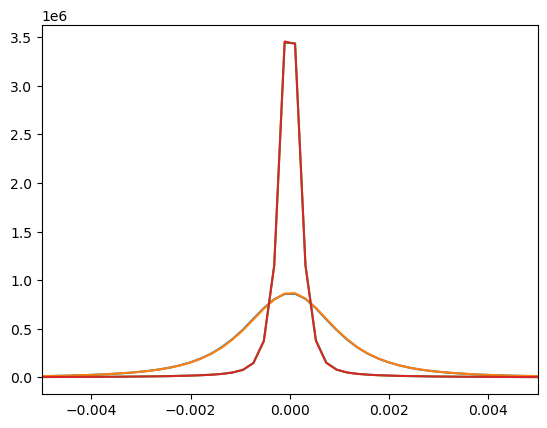

In [25]:
bin_edges=np.linspace(-0.02-0.001,0.02+0.001,201) 
bin_mids=(bin_edges[1:]+bin_edges[:-1])/2
PDF_g1, _ = np.histogram(GalCat_NLA[:,3], bin_edges, density=False)
PDF_g2, _ = np.histogram(GalCat_NLA[:,4], bin_edges, density=False)

PDF_eIA1_NLA, _ = np.histogram(GalCat_NLA[:,11], bin_edges, density=False)
PDF_eIA2_NLA, _ = np.histogram(GalCat_NLA[:,12]/2, bin_edges, density=False)
PDF_eIA1_TT, _ = np.histogram(GalCat_TT[:,11], bin_edges, density=False)
PDF_eIA2_TT, _ = np.histogram(GalCat_TT[:,12]/2, bin_edges, density=False)

#plt.plot(bin_mids, PDF_g1.T)
#plt.plot(bin_mids, PDF_g2.T)
plt.plot(bin_mids, PDF_eIA1_NLA.T)
plt.plot(bin_mids, PDF_eIA2_NLA.T)
plt.plot(bin_mids, PDF_eIA1_TT.T)
plt.plot(bin_mids, PDF_eIA2_TT.T)
#plt.fill_between(binMid, PDF - PDF_standard_deviation, PDF + PDF_standard_deviation, alpha=0.5)
plt.xlim(-0.005,0.005)

#plt.semilogy()
plt.show()

In [ ]:
# Visualise the mask file
hpmap_weight = hp.fitsfunc.read_map('./IA-infusion/SkySim5000/FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
#
# masking - not really necessary here, but just in case it is useful for something else.
unmask = np.where(hpmap_weight > 0)[0]


NSIDE=8192
pixel_area_arcmin2 = hp.pixelfunc.nside2pixarea(nside=NSIDE)*(180*60/np.pi)**2
octant_area_arcmin2 = sum(unmask)*pixel_area_arcmin2